# 03B — Sector Behavior by Regime

**Purpose**: How sectors behave in each regime (returns, volatility, drawdowns)

**This explains why correlations flip.**

**Output**: Regime-conditional performance tables

---

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

PROCESSED_PATH = Path('../data_processed')

# Load data
combined = pd.read_parquet(PROCESSED_PATH / 'macro_sector_monthly_matrix.parquet')
regime_states = pd.read_parquet(PROCESSED_PATH / 'macro_regime_states.parquet')

print(f"Combined matrix: {combined.shape}")
print(f"Regime states: {regime_states.shape}")

Combined matrix: (132, 93)
Regime states: (132, 5)


## 1. Prepare Sector Returns and Regime Labels

In [2]:
# Extract sector returns
index_cols = [c for c in combined.columns if c.startswith('IDX_')]
sector_returns = combined[index_cols].copy()

# Clean column names
sector_returns.columns = [c.replace('IDX_', '').replace('NIFTY_', '') for c in sector_returns.columns]

# Get composite regime
if 'COMPOSITE' in regime_states.columns:
    regime = regime_states['COMPOSITE']
else:
    regime = pd.Series('Unknown', index=regime_states.index)

# Align data
common_idx = sector_returns.index.intersection(regime.index)
sector_returns = sector_returns.loc[common_idx]
regime = regime.loc[common_idx]

print(f"Analysis period: {len(common_idx)} months")
print(f"Sectors: {len(sector_returns.columns)}")
print(f"\nRegime distribution:")
print(regime.value_counts())

Analysis period: 132 months
Sectors: 21

Regime distribution:
COMPOSITE
Reflation      92
Goldilocks     23
Deflation      11
Stagflation     6
Name: count, dtype: int64


## 2. Calculate Regime-Conditional Returns

In [3]:
def calculate_regime_performance(returns: pd.DataFrame, regime: pd.Series) -> pd.DataFrame:
    """
    Calculate performance metrics by regime.
    """
    results = []
    
    for regime_name in regime.unique():
        if regime_name == 'Unknown':
            continue
            
        mask = regime == regime_name
        regime_returns = returns[mask]
        
        if len(regime_returns) < 6:  # Need at least 6 months
            continue
        
        for sector in returns.columns:
            sector_ret = regime_returns[sector].dropna()
            if len(sector_ret) < 6:
                continue
            
            # Calculate metrics
            mean_return = sector_ret.mean()
            annualized_return = mean_return * 12
            volatility = sector_ret.std() * np.sqrt(12)
            sharpe = annualized_return / volatility if volatility > 0 else 0
            
            # Win rate
            win_rate = (sector_ret > 0).mean() * 100
            
            # Max drawdown (simplified monthly)
            cumulative = (1 + sector_ret / 100).cumprod()
            running_max = cumulative.cummax()
            drawdown = (cumulative - running_max) / running_max
            max_dd = drawdown.min() * 100
            
            results.append({
                'regime': regime_name,
                'sector': sector,
                'months': len(sector_ret),
                'mean_monthly': mean_return,
                'annualized_return': annualized_return,
                'volatility': volatility,
                'sharpe': sharpe,
                'win_rate': win_rate,
                'max_drawdown': max_dd
            })
    
    return pd.DataFrame(results)

# Calculate performance
regime_performance = calculate_regime_performance(sector_returns, regime)
print(f"Performance records: {len(regime_performance)}")

Performance records: 84

## 3. Regime Performance Heatmap

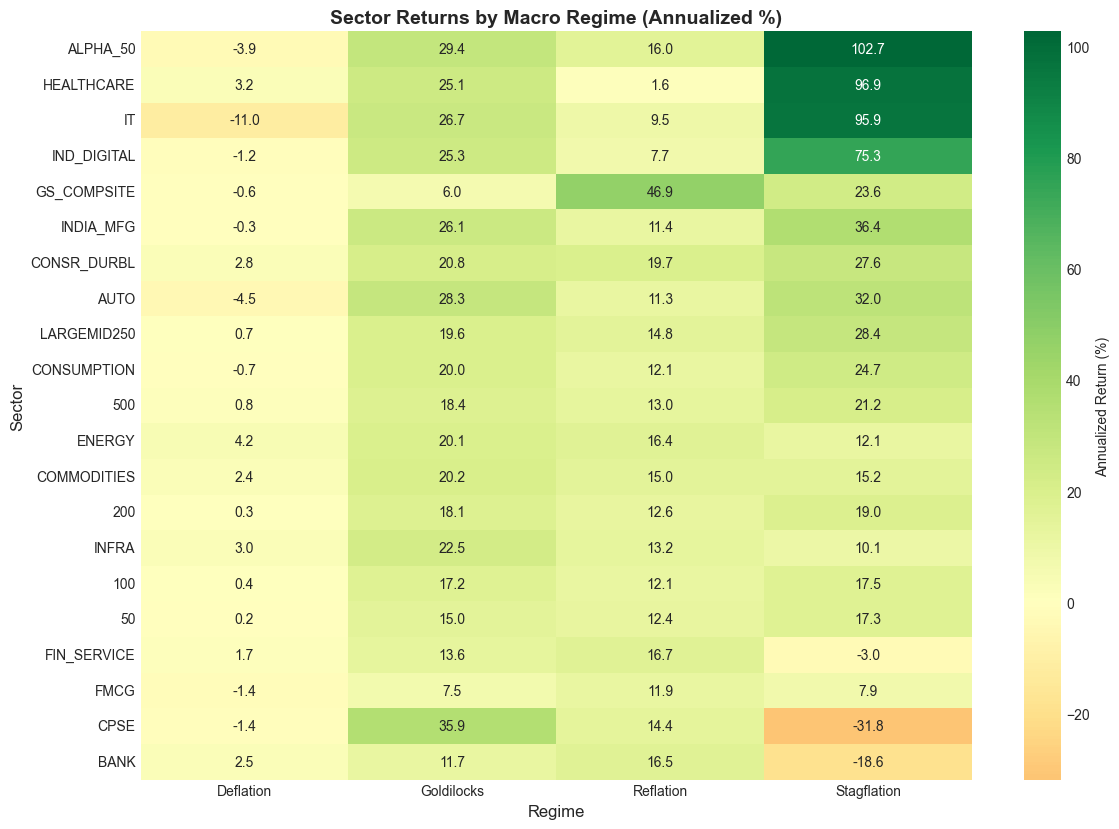

✓ Saved: sector_regime_heatmap.png


In [4]:
# Pivot for heatmap
if len(regime_performance) > 0:
    return_pivot = regime_performance.pivot(
        index='sector', 
        columns='regime', 
        values='annualized_return'
    )
    
    # Sort by average return
    return_pivot['avg'] = return_pivot.mean(axis=1)
    return_pivot = return_pivot.sort_values('avg', ascending=False)
    return_pivot = return_pivot.drop('avg', axis=1)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, max(8, len(return_pivot) * 0.4)))
    
    sns.heatmap(
        return_pivot,
        cmap='RdYlGn',
        center=0,
        annot=True,
        fmt='.1f',
        ax=ax,
        cbar_kws={'label': 'Annualized Return (%)'}
    )
    
    ax.set_title('Sector Returns by Macro Regime (Annualized %)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Regime', fontsize=12)
    ax.set_ylabel('Sector', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'sector_regime_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: sector_regime_heatmap.png")
else:
    print("Insufficient data for heatmap")

## 4. Regime Winners and Losers

In [5]:
# Find best and worst performers per regime
if len(regime_performance) > 0:
    for regime_name in regime_performance['regime'].unique():
        regime_data = regime_performance[regime_performance['regime'] == regime_name]
        regime_data = regime_data.sort_values('annualized_return', ascending=False)
        
        print(f"\n=== {regime_name.upper()} ===")
        print(f"\n🏆 TOP 5 Performers:")
        for _, row in regime_data.head(5).iterrows():
            print(f"  {row['sector']}: {row['annualized_return']:.1f}% (Sharpe: {row['sharpe']:.2f})")
        
        print(f"\n📉 BOTTOM 5 Performers:")
        for _, row in regime_data.tail(5).iterrows():
            print(f"  {row['sector']}: {row['annualized_return']:.1f}% (Sharpe: {row['sharpe']:.2f})")


=== REFLATION ===

🏆 TOP 5 Performers:
  GS_COMPSITE: 46.9% (Sharpe: 0.42)
  CONSR_DURBL: 19.7% (Sharpe: 0.47)
  FIN_SERVICE: 16.7% (Sharpe: 0.80)
  BANK: 16.5% (Sharpe: 0.80)
  ENERGY: 16.4% (Sharpe: 0.64)

📉 BOTTOM 5 Performers:
  INDIA_MFG: 11.4% (Sharpe: 0.50)
  AUTO: 11.3% (Sharpe: 0.46)
  IT: 9.5% (Sharpe: 0.32)
  IND_DIGITAL: 7.7% (Sharpe: 0.24)
  HEALTHCARE: 1.6% (Sharpe: 0.09)

=== GOLDILOCKS ===

🏆 TOP 5 Performers:
  CPSE: 35.9% (Sharpe: 0.95)
  ALPHA_50: 29.4% (Sharpe: 1.00)
  AUTO: 28.3% (Sharpe: 1.04)
  IT: 26.7% (Sharpe: 1.38)
  INDIA_MFG: 26.1% (Sharpe: 0.93)

📉 BOTTOM 5 Performers:
  50: 15.0% (Sharpe: 1.00)
  FIN_SERVICE: 13.6% (Sharpe: 0.99)
  BANK: 11.7% (Sharpe: 0.97)
  FMCG: 7.5% (Sharpe: 0.71)
  GS_COMPSITE: 6.0% (Sharpe: 0.85)

=== DEFLATION ===

🏆 TOP 5 Performers:
  ENERGY: 4.2% (Sharpe: 0.23)
  HEALTHCARE: 3.2% (Sharpe: 0.33)
  INFRA: 3.0% (Sharpe: 0.16)
  CONSR_DURBL: 2.8% (Sharpe: 0.18)
  BANK: 2.5% (Sharpe: 0.12)

📉 BOTTOM 5 Performers:
  CPSE: -1.4% (Sha

## 5. Volatility by Regime

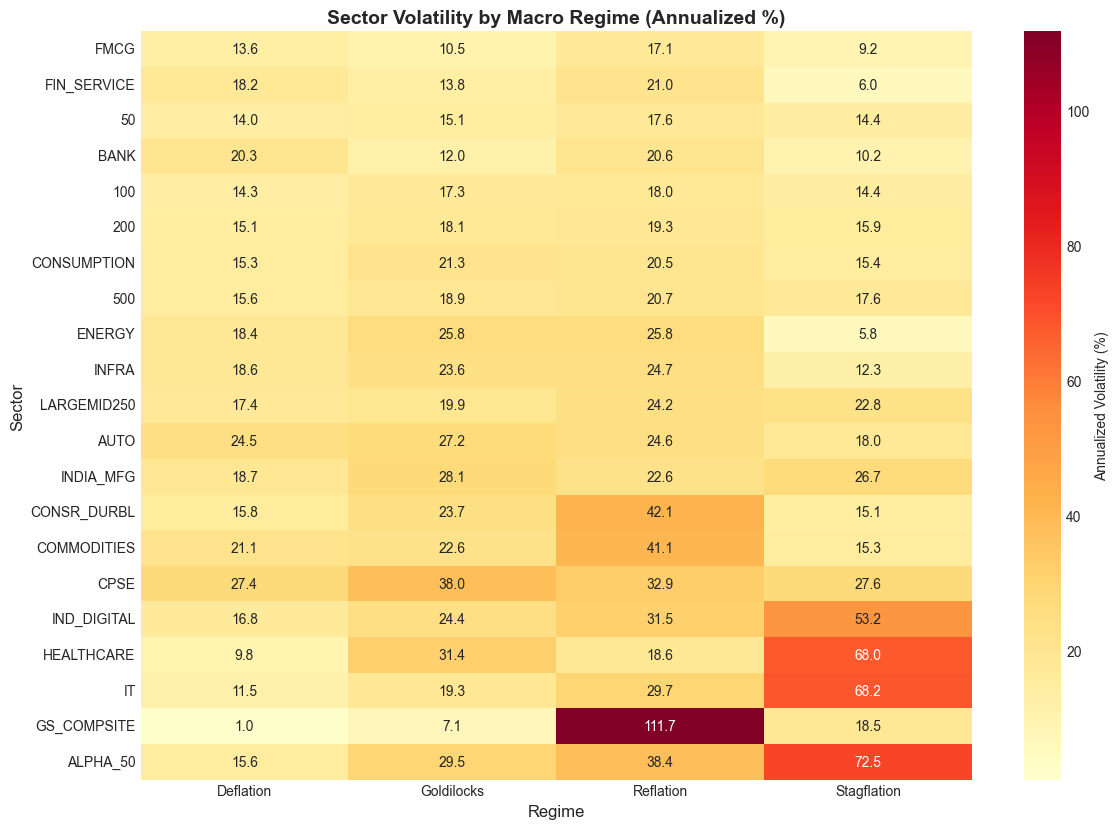

✓ Saved: sector_regime_volatility.png


In [6]:
if len(regime_performance) > 0:
    vol_pivot = regime_performance.pivot(
        index='sector', 
        columns='regime', 
        values='volatility'
    )
    
    # Sort by average volatility
    vol_pivot['avg'] = vol_pivot.mean(axis=1)
    vol_pivot = vol_pivot.sort_values('avg', ascending=True)
    vol_pivot = vol_pivot.drop('avg', axis=1)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, max(8, len(vol_pivot) * 0.4)))
    
    sns.heatmap(
        vol_pivot,
        cmap='YlOrRd',
        annot=True,
        fmt='.1f',
        ax=ax,
        cbar_kws={'label': 'Annualized Volatility (%)'}
    )
    
    ax.set_title('Sector Volatility by Macro Regime (Annualized %)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Regime', fontsize=12)
    ax.set_ylabel('Sector', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'sector_regime_volatility.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: sector_regime_volatility.png")

## 6. Sharpe Ratio by Regime

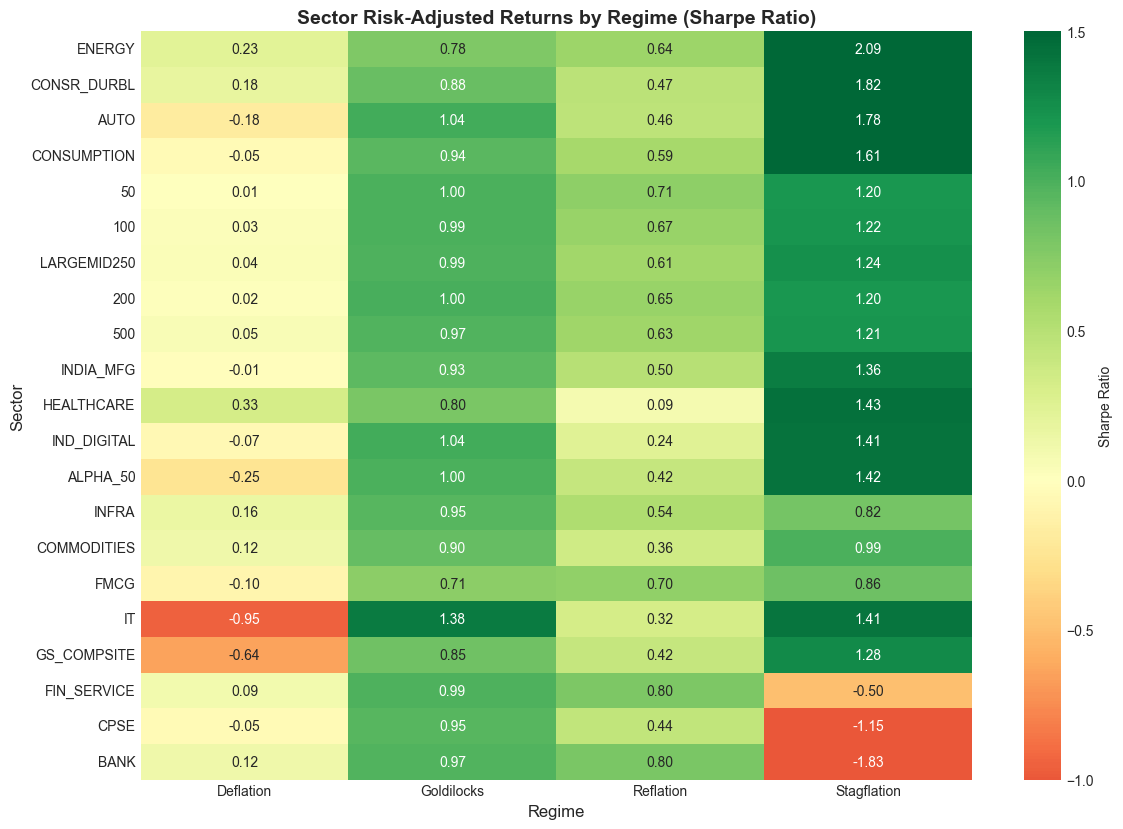

✓ Saved: sector_regime_sharpe.png


In [7]:
if len(regime_performance) > 0:
    sharpe_pivot = regime_performance.pivot(
        index='sector', 
        columns='regime', 
        values='sharpe'
    )
    
    # Sort by average Sharpe
    sharpe_pivot['avg'] = sharpe_pivot.mean(axis=1)
    sharpe_pivot = sharpe_pivot.sort_values('avg', ascending=False)
    sharpe_pivot = sharpe_pivot.drop('avg', axis=1)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, max(8, len(sharpe_pivot) * 0.4)))
    
    sns.heatmap(
        sharpe_pivot,
        cmap='RdYlGn',
        center=0,
        vmin=-1,
        vmax=1.5,
        annot=True,
        fmt='.2f',
        ax=ax,
        cbar_kws={'label': 'Sharpe Ratio'}
    )
    
    ax.set_title('Sector Risk-Adjusted Returns by Regime (Sharpe Ratio)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Regime', fontsize=12)
    ax.set_ylabel('Sector', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'sector_regime_sharpe.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: sector_regime_sharpe.png")

## 7. Regime Rotation Strategy Hints

In [8]:
# For each regime, identify optimal sector allocation
if len(regime_performance) > 0:
    print("\n🎯 REGIME ROTATION PLAYBOOK")
    print("="*50)
    
    for regime_name in ['Goldilocks', 'Reflation', 'Stagflation', 'Deflation']:
        regime_data = regime_performance[regime_performance['regime'] == regime_name]
        
        if len(regime_data) < 3:
            continue
            
        # Best 3 by Sharpe
        best = regime_data.nlargest(3, 'sharpe')
        
        print(f"\n{regime_name.upper()}:")
        print(f"  Overweight: {', '.join(best['sector'].tolist())}")
        
        # Worst 3 by Sharpe
        worst = regime_data.nsmallest(3, 'sharpe')
        print(f"  Underweight: {', '.join(worst['sector'].tolist())}")


🎯 REGIME ROTATION PLAYBOOK

GOLDILOCKS:
  Overweight: IT, AUTO, IND_DIGITAL
  Underweight: FMCG, ENERGY, HEALTHCARE

REFLATION:
  Overweight: BANK, FIN_SERVICE, 50
  Underweight: HEALTHCARE, IND_DIGITAL, IT

STAGFLATION:
  Overweight: ENERGY, CONSR_DURBL, AUTO
  Underweight: BANK, CPSE, FIN_SERVICE

DEFLATION:
  Overweight: HEALTHCARE, ENERGY, CONSR_DURBL
  Underweight: IT, GS_COMPSITE, ALPHA_50


## 8. Export Regime Performance

In [9]:
# Save detailed performance
if len(regime_performance) > 0:
    regime_performance.to_parquet(PROCESSED_PATH / 'sector_regime_performance.parquet', index=False)
    print("✓ Saved: sector_regime_performance.parquet")
    
    # Also save as CSV for easy viewing
    regime_performance.to_csv(PROCESSED_PATH / 'sector_regime_performance.csv', index=False)
    print("✓ Saved: sector_regime_performance.csv")

✓ Saved: sector_regime_performance.parquet
✓ Saved: sector_regime_performance.csv


## 9. Key Insights ✓

### Why This Matters

1. **Correlations flip**: A sector that works in Goldilocks may fail in Stagflation
2. **Volatility varies**: Same sector can have 2x volatility in crisis vs calm
3. **Rotation signals**: Regime changes are early signals for sector rotation

### Outputs
- `sector_regime_performance.parquet` — Full performance table
- `sector_regime_heatmap.png` — Returns by regime
- `sector_regime_volatility.png` — Risk by regime
- `sector_regime_sharpe.png` — Risk-adjusted returns

**LAYER 3 REGIMES COMPLETE**

**Next notebook:** `04A_macro_conditioned_rules.ipynb`